In [1]:
import os
import math
from typing import Callable

import pandas as pd
import numpy as np
from fklearn.training.transformation import onehot_categorizer, custom_transformer, count_categorizer
from fklearn.training.regression import xgb_regression_learner, rf_regression_learner
from fklearn.training.pipeline import build_pipeline
from fklearn.validation.evaluators import r2_evaluator, mse_evaluator, combined_evaluators
from fklearn.training.imputation import imputer
from fklearn.preprocessing.splitting import time_split_dataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from helpers import (display_all, to_snake_case, add_date_parts,
                     tranform_columns_to_categorical, separate_features_by_dtype,
                    to_normalized_string, draw_tree)

/home/giuliano/Documents/courses/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def print_metrics(df_train: pd.DataFrame, df_test: pd.DataFrame, predict_fn: Callable):
    evaluator_fn = combined_evaluators(evaluators=[r2_evaluator(target_column="sale_price"),
                                                   mse_evaluator(target_column="sale_price")])
    df_train = predict_fn(df_train.copy())
    metrics_train = evaluator_fn(df_train)

    df_test = predict_fn(df_test.copy())
    metrics_test = evaluator_fn(df_test)

    print(f"""
Metrics Train:
    RMSE: {math.sqrt(metrics_train["mse_evaluator__sale_price"])}
    R2: {metrics_train["r2_evaluator__sale_price"]}
Metrics Test:
    RMSE: {math.sqrt(metrics_test["mse_evaluator__sale_price"])}
    R2: {metrics_test["r2_evaluator__sale_price"]}
""")

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
DATA_PATH = "../data/bluebook-for-bulldozers/"

In [5]:
df_raw = pd.read_csv(f'{DATA_PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

In [7]:
df_raw = df_raw.rename(mapper=to_snake_case, axis=1)

In [8]:
columns_dtype = separate_features_by_dtype(df_raw)
categorical_columns = columns_dtype["object"]

In [9]:
df_raw["sale_price"] = np.log(df_raw["sale_price"])
df_raw = add_date_parts(df_raw)
df_raw[categorical_columns] = df_raw[categorical_columns].applymap(str).applymap(to_normalized_string)
df_raw = tranform_columns_to_categorical(df_raw, ordered={"usage_band": ["high", "medium", "low"]})

In [10]:
display_all(df_raw.head().T)

,0,1,2,3,4
sales_id,1139246,1139248,1139249,1139251,1139253
sale_price,11.0974,10.9508,9.21034,10.5584,9.30565
machine_id,999089,117657,434808,1026470,1057373
model_id,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneer_id,3,3,3,3,3
year_made,2004,1996,2001,2001,2007
machine_hours_current_meter,68,4640,2838,3486,722
usage_band,low,low,high,high,medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [11]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

### Reload

In [22]:
SAMPLE_FRAC = 1

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=1111)
columns_dtype = separate_features_by_dtype(df_raw)

print(f"Sample size: {len(df_raw)}")

Sample size: 401125


## Processors

### One-Hot Encoder

In [13]:
categorical_columns = columns_dtype["category"]
high_dimensional_columns = list(filter(lambda c: len(df_raw[c].unique()) > 100, categorical_columns))
categorical_columns = filter(lambda x: x not in high_dimensional_columns, categorical_columns)
categorical_columns = list(categorical_columns)

In [14]:
onehot_encoder_fn = onehot_categorizer(columns_to_categorize=categorical_columns,
                                       hardcode_nans=True,
                                       drop_first_column=True)

### Count encoder for high dimensional features

In [15]:
count_encoder_fn = count_categorizer(columns_to_categorize=high_dimensional_columns)

### Simple Continous Imputer

In [16]:
continuous_features = columns_dtype["float64"] + columns_dtype["int64"]
median_imputer_fn = imputer(columns_to_impute=continuous_features)

## Create Learners

### Feature Selection

In [17]:
banned_columns = ["sale_price", "sales_id"] + columns_dtype["datetime64[ns]"]

features = df_raw.columns
features = filter(lambda x: x not in banned_columns, features)
features = list(features)

### XGB Trainer

In [18]:
xgb_learner_fn = xgb_regression_learner(features=features,
                                        target="sale_price",
                                        encode_extra_cols=True)

### Random Forest Trainer

In [19]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1})

## Training

### Train vs Test

In [23]:
SAMPLE_FRAC = 0.05
train_test_row_limit = int(len(df_raw) * (1 - SAMPLE_FRAC))

train_start_date = df_raw["saledate"].min()
train_end_date = df_raw["saledate"].sort_values().reset_index(drop=True)[train_test_row_limit]
holdout_end_date = df_raw["saledate"].max()

df_train, df_test = time_split_dataset(
    df_raw,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    holdout_end_date=holdout_end_date,
    time_column="saledate"
)

print(f"Train Shape: {df_train.shape}, Test Shape: {df_test.shape}")

Train Shape: (381068, 65), Test Shape: (19997, 65)


### Training XGB

In [24]:
xgb_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, xgb_learner_fn)
predict_fn, _, logs = xgb_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.25238188626617747
    R2: 0.8671007316763977
Metrics Test:
    RMSE: 0.2763565199959118
    R2: 0.8506505431446838



### Training RF

In [25]:
rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

/home/giuliano/Documents/courses/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Metrics Train:
    RMSE: 0.09129543513788625
    R2: 0.9826098089980643
Metrics Test:
    RMSE: 0.25893779222977065
    R2: 0.8688841790157034



## Single Tree

In [29]:
params = {
    "n_jobs": -1,
    "n_estimators": 1,
    "max_depth": 3,
    "bootstrap": False,
}

single_tree_rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params=params)

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, single_tree_rf_learner_fn)
predict_fn, df_s, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.5231462180316607
    R2: 0.42897857138565454
Metrics Test:
    RMSE: 0.530497359641463
    R2: 0.44966051829422105



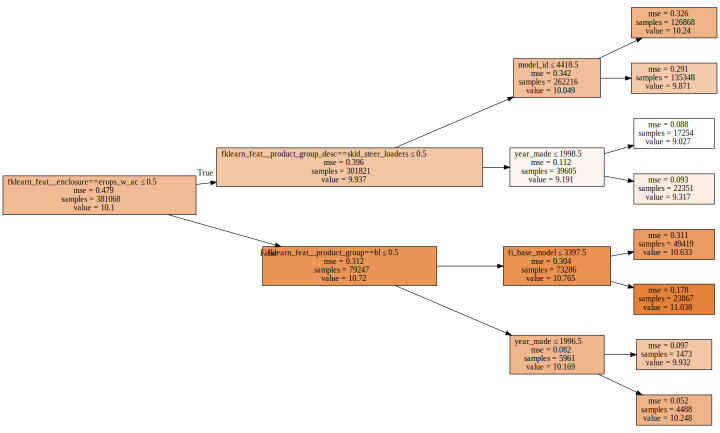

In [30]:
model_object = logs["rf_regression_learner"]["model_object"]
variables = logs["rf_regression_learner"]["features"]
draw_tree(model_object.estimators_[0], df_s[variables], precision=3)

In [31]:
params = {
    "n_jobs": -1,
    "n_estimators": 1,
    "bootstrap": False,
}

single_tree_rf_learner_fn = rf_regression_learner(
    features=features,
    target="sale_price",
    encode_extra_cols=True,
    extra_params=params
)

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, single_tree_rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 8.896342494526444e-07
    R2: 0.9999999999983487
Metrics Test:
    RMSE: 0.3467398565994691
    R2: 0.7648896502342756



## Bagging

### Intro to Bagging

In [32]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

/home/giuliano/Documents/courses/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Metrics Train:
    RMSE: 0.09185035447309609
    R2: 0.9823977615635292
Metrics Test:
    RMSE: 0.259055525053816
    R2: 0.8687649214513038



In [33]:
preprocessor_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn)
preprocessor_fn, _, _ = preprocessor_learner(df_train)

model = logs["rf_regression_learner"]["model_object"]
columns = logs["rf_regression_learner"]["features"]

test_matrix_X = preprocessor_fn(df_test)[columns].values
test_vector_y = df_test["sale_price"].values

In [34]:
preds = np.stack([t.predict(test_matrix_X) for t in model.estimators_])

print(f"""
Prediction for the 10 trees: {preds[:,0]},
Mean prediction for the 10 trees: {np.mean(preds[:,0])}
Real value: {test_vector_y[0]}
""")


Prediction for the 10 trees: [9.21034037 9.21034037 9.79812704 9.30565055 9.30565055 9.47270464
 9.39266193 9.35010231 9.25913054 9.30565055],
Mean prediction for the 10 trees: 9.361035885188295
Real value: 9.350102314351341



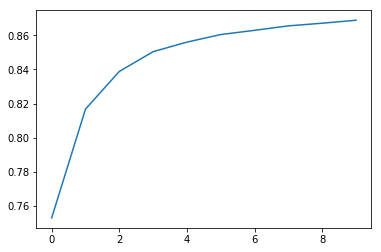

In [35]:
plt.plot([r2_score(test_vector_y, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [36]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 20})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, _ = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.0838097985665253
    R2: 0.9853446626502742
Metrics Test:
    RMSE: 0.2539032332860515
    R2: 0.873933214314245



In [37]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 40})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, _ = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.07988053795093217
    R2: 0.9866866242939124
Metrics Test:
    RMSE: 0.2497066011206242
    R2: 0.8780661564457467



In [38]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 80})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, _ = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.07747051818007097
    R2: 0.9874778429041933
Metrics Test:
    RMSE: 0.2488106559470717
    R2: 0.878939581907503



### OOB Score

In [39]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 40, "oob_score": True})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.07972514249776884
    R2: 0.986738372211463
Metrics Test:
    RMSE: 0.2508635792927591
    R2: 0.8769336143400926

OOB R2: 0.9056923398961763


## Reducing Overfitting

In [40]:
from sklearn.ensemble import forest


def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

### Subsampling

In [41]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
set_rf_samples(20000)

In [42]:
train_test_row_limit = int(len(df_raw) - 12000)

train_start_date = df_raw["saledate"].min()
train_end_date = df_raw["saledate"].sort_values().reset_index(drop=True)[train_test_row_limit]
holdout_end_date = df_raw["saledate"].max()

df_train, df_test = time_split_dataset(
    df_raw,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    holdout_end_date=holdout_end_date,
    time_column="saledate"
)

print(f"Train Shape: {df_train.shape}, Test Shape: {df_test.shape}")

Train Shape: (389050, 65), Test Shape: (12015, 65)


In [43]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")

/home/giuliano/Documents/courses/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Metrics Train:
    RMSE: 0.24656380713865167
    R2: 0.8732493269688566
Metrics Test:
    RMSE: 0.2856187022128885
    R2: 0.8438580662553573

OOB R2: 0.8600003306452353


In [44]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True, "n_estimators": 40})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.2335754089920674
    R2: 0.8862514536065856
Metrics Test:
    RMSE: 0.2745880017766195
    R2: 0.8556856944215727

OOB R2: 0.874051740185006


In [45]:
reset_rf_samples()

### Tree building parameters

In [46]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True, "n_estimators": 40, "min_samples_leaf": 5})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.14877309626044322
    R2: 0.9538533241031563
Metrics Test:
    RMSE: 0.24548636036085691
    R2: 0.8846544074024921

OOB R2: 0.9022110367761532


In [47]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True, "n_estimators": 40, "min_samples_leaf": 3})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.12158632918528439
    R2: 0.9691779789115577
Metrics Test:
    RMSE: 0.24500381489880418
    R2: 0.8851074247356281

OOB R2: 0.9043692462643368


In [48]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1,
                                                    "oob_score": True,
                                                    "n_estimators": 40,
                                                    "min_samples_leaf": 3,
                                                    "max_features": 0.5})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.12664581588673987
    R2: 0.9665594576869658
Metrics Test:
    RMSE: 0.23926933067310716
    R2: 0.8904227643692301

OOB R2: 0.907183939184625
